In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from Energy_Models.NBEATS import NBeatsNet

In [2]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [3]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [4]:
fill_missing(df.values)

In [5]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)


In [7]:
df.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [8]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [9]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [10]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [11]:
X_test.shape
X_train.shape

(1009, 8)

In [12]:
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [13]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [14]:
def convert_to_supervised(df):

    input_features = []
    ouput_feature = []
    
    len_df = df.shape[0]
    
    for i in range(len_df):
        
        end_idx = i + 21
        
        if end_idx > len_df-7:
            break
            
        input_x , output_y = df[i:end_idx, 1:], df[end_idx: end_idx+7, 0]
        
        input_features.append(input_x)
        ouput_feature.append(output_y)
    
    return np.array(input_features), np.array(ouput_feature)


In [15]:
# Split the training data into input features and out feature
X_train, Y_train = convert_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [16]:
# Split the testing data into input features and out feature
X_test, Y_test = convert_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))


Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = NBeatsNet(21,7,7)

In [21]:
model.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 21, 7)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 21)           0           ['input_variable[0][0]']         
                                                                                                  
 lambda_1 (Lambda)              (None, 21)           0           ['input_variable[0][0]']         
                                                                                                  
 lambda_2 (Lambda)              (None, 21)           0           ['input_variable[0][0]']         
                                                                                           

 subtract_3 (Subtract)          (None, 21)           0           ['lambda_3[0][0]',               
                                                                  'lambda_7[3][0]']               
                                                                                                  
 subtract_4 (Subtract)          (None, 21)           0           ['lambda_4[0][0]',               
                                                                  'lambda_7[4][0]']               
                                                                                                  
 subtract_5 (Subtract)          (None, 21)           0           ['lambda_5[0][0]',               
                                                                  'lambda_7[5][0]']               
                                                                                                  
 subtract_6 (Subtract)          (None, 21)           0           ['lambda_6[0][0]',               
          

                                                                  'lambda_9[5][0]']               
                                                                                                  
 subtract_13 (Subtract)         (None, 21)           0           ['subtract_6[0][0]',             
                                                                  'lambda_9[6][0]']               
                                                                                                  
 0/2/trend/d1 (Dense)           (None, 256)          5632        ['subtract_7[0][0]',             
                                                                  'subtract_8[0][0]',             
                                                                  'subtract_9[0][0]',             
                                                                  'subtract_10[0][0]',            
                                                                  'subtract_11[0][0]',            
          

                                                                  'subtract_16[0][0]',            
                                                                  'subtract_17[0][0]',            
                                                                  'subtract_18[0][0]',            
                                                                  'subtract_19[0][0]',            
                                                                  'subtract_20[0][0]']            
                                                                                                  
 1/0/seasonality/d2 (Dense)     (None, 256)          65792       ['1/0/seasonality/d1[0][0]',     
                                                                  '1/0/seasonality/d1[1][0]',     
                                                                  '1/0/seasonality/d1[2][0]',     
                                                                  '1/0/seasonality/d1[3][0]',     
          

 1/1/seasonality/d3 (Dense)     (None, 256)          65792       ['1/1/seasonality/d2[0][0]',     
                                                                  '1/1/seasonality/d2[1][0]',     
                                                                  '1/1/seasonality/d2[2][0]',     
                                                                  '1/1/seasonality/d2[3][0]',     
                                                                  '1/1/seasonality/d2[4][0]',     
                                                                  '1/1/seasonality/d2[5][0]',     
                                                                  '1/1/seasonality/d2[6][0]']     
                                                                                                  
 1/1/seasonality/d4 (Dense)     (None, 256)          65792       ['1/1/seasonality/d3[0][0]',     
                                                                  '1/1/seasonality/d3[1][0]',     
          

                                                                  '1/2/seasonality/d1[6][0]']     
                                                                                                  
 stack_0-TrendBlock_0_Dim_0 (La  (None, 7)           0           ['lambda_8[0][0]']               
 mbda)                                                                                            
                                                                                                  
 stack_0-TrendBlock_1_Dim_0 (La  (None, 7)           0           ['lambda_10[0][0]']              
 mbda)                                                                                            
                                                                                                  
 lambda_12 (Lambda)             (None, 7)            0           ['0/2/trend/theta_f_b[0][0]',    
                                                                  '0/2/trend/theta_f_b[2][0]',    
          

                                                                                                  
 1/1/seasonality/theta_f (Dense  (None, 7)           1792        ['1/1/seasonality/d4[0][0]',     
 )                                                                '1/1/seasonality/d4[1][0]',     
                                                                  '1/1/seasonality/d4[2][0]',     
                                                                  '1/1/seasonality/d4[3][0]',     
                                                                  '1/1/seasonality/d4[4][0]',     
                                                                  '1/1/seasonality/d4[5][0]',     
                                                                  '1/1/seasonality/d4[6][0]']     
                                                                                                  
 1/2/seasonality/d4 (Dense)     (None, 256)          65792       ['1/2/seasonality/d3[0][0]',     
          

                                                                  '1/2/seasonality/d4[3][0]',     
                                                                  '1/2/seasonality/d4[4][0]',     
                                                                  '1/2/seasonality/d4[5][0]',     
                                                                  '1/2/seasonality/d4[6][0]']     
                                                                                                  
 add_8 (Add)                    (None, 7)            0           ['add_1[0][0]',                  
                                                                  'stack_0-TrendBlock_2_Dim_1[0][0
                                                                 ]']                              
                                                                                                  
 stack_1-SeasonalityBlock_0_Dim  (None, 7)           0           ['lambda_14[1][0]']              
 _1 (Lambd

 add_18 (Add)                   (None, 7)            0           ['add_11[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 4[0][0]']                        
                                                                                                  
 stack_1-SeasonalityBlock_1_Dim  (None, 7)           0           ['lambda_16[4][0]']              
 _4 (Lambda)                                                                                      
                                                                                                  
 add_19 (Add)                   (None, 7)            0           ['add_12[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_0_Dim_
                                                                 5[0][0]']                        
          

                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 3[0][0]']                        
                                                                                                  
 add_32 (Add)                   (None, 7)            0           ['add_25[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 4[0][0]']                        
                                                                                                  
 add_33 (Add)                   (None, 7)            0           ['add_26[0][0]',                 
                                                                  'stack_1-SeasonalityBlock_2_Dim_
                                                                 5[0][0]']                        
          

In [22]:
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=100, batch_size=64, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/100
13/13 [==============================] - 28s 296ms/step - loss: 0.0411 - val_loss: 0.0262
Epoch 2/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0205 - val_loss: 0.0075
Epoch 3/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0140 - val_loss: 0.0050
Epoch 4/100
13/13 [==============================] - 1s 49ms/step - loss: 0.0122 - val_loss: 0.0045
Epoch 5/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0113 - val_loss: 0.0046
Epoch 6/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 7/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 8/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0096 - val_loss: 0.0046
Epoch 9/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 10/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0087 - val_loss: 0.00

In [23]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
def print_metrics():
    print('Train   RMSE  value   : %.3f ' % root_mean_squared_error(Y_train, model.predict(X_train)))
    print('Train   MSE   value   : %.3f ' % mean_squared_error(Y_train, model.predict(X_train)))
    print('Train   R2    value   : %.3f ' % r2_score(Y_train,model.predict(X_train)))
    print('Train   MAPE  value   : %.3f ' % mean_absolute_percentage_error(Y_train, model.predict(X_train)))
    print('Train   MAE   value   : %.3f ' % mean_absolute_error(Y_train, model.predict(X_train)))
    print('---------------------------------------------')
    print('Test    RMSE  value   : %.3f ' % root_mean_squared_error(Y_test, model.predict(X_test)))
    print('Test    MSE   value   : %.3f ' % mean_squared_error(Y_test, model.predict(X_test)))
    print('Test    R2    value   : %.3f ' % r2_score(Y_test, model.predict(X_test)))
    print('Test    MAPE  value   : %.3f ' % mean_absolute_percentage_error(Y_test, model.predict(X_test)))
    print('Test    MAE   value   : %.3f ' % mean_absolute_error(Y_test, model.predict(X_test)))

In [24]:
print_metrics()

31/31 [==============================] - 3s 6ms/step
Train   RMSE  value   : 0.049 
31/31 [==============================] - 0s 7ms/step
Train   MSE   value   : 0.002 
31/31 [==============================] - 0s 6ms/step
Train   R2    value   : 0.873 
31/31 [==============================] - 0s 5ms/step
Train   MAPE  value   : 12287455258.169 
31/31 [==============================] - 0s 7ms/step
Train   MAE   value   : 0.034 
---------------------------------------------
13/13 [==============================] - 0s 7ms/step
Test    RMSE  value   : 0.106 
13/13 [==============================] - 0s 5ms/step
Test    MSE   value   : 0.011 
13/13 [==============================] - 0s 6ms/step
Test    R2    value   : 0.019 
13/13 [==============================] - 0s 7ms/step
Test    MAPE  value   : 0.346 
13/13 [==============================] - 0s 6ms/step
Test    MAE   value   : 0.083 


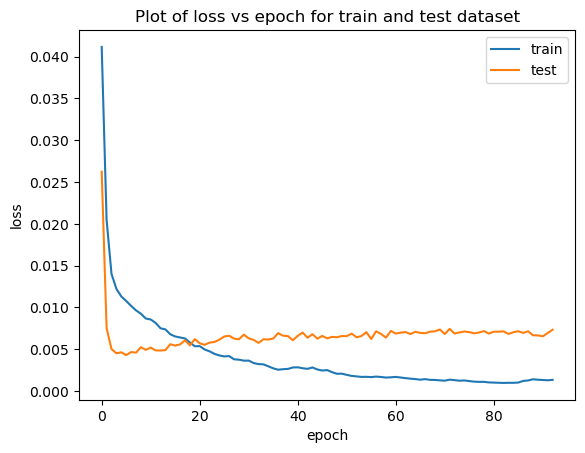

In [25]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()